In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


/content/drive/MyDrive/VR/coins.jpg

In [202]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [203]:
path = "/content/drive/MyDrive/VR/coins.jpg"

In [204]:
def read_image(path):
    if os.path.exists(path):
      img = cv2.imread(path)
      imgrgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
      plt.imshow(imgrgb)
      plt.title("Original Image of coins")
      plt.axis('off')
      return img
    else:
      print("file not found")
      exit()

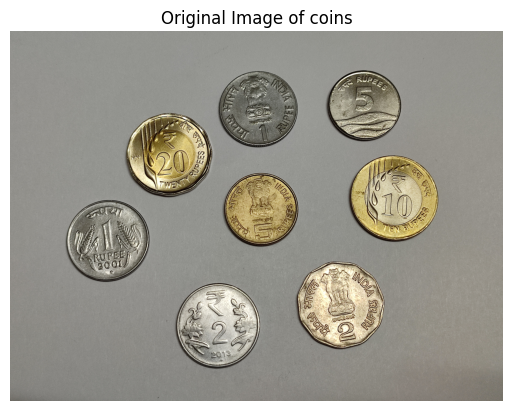

In [205]:
img = read_image(path)

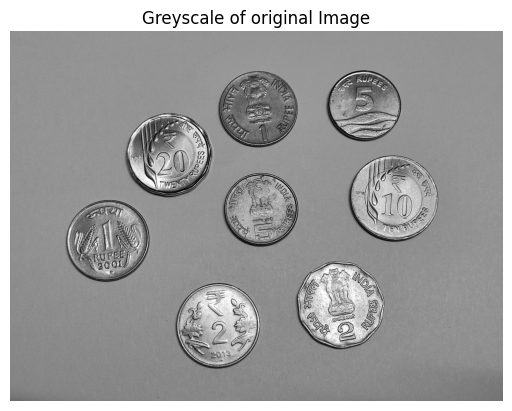

In [206]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap='gray')
plt.title("Greyscale of original Image")
plt.axis('off')
plt.show()

#Downsample images based on size

In [207]:
print(gray.shape)

(3000, 4000)


In [208]:
def downsample_images(image):

  if image.shape[0] > 512 or image.shape[1] > 512:
    while image.shape[0] > 512 or image.shape[1] > 512:
      image = cv2.pyrDown(image)

  return image

In [209]:
gray = downsample_images(gray)
print(gray.shape)

(375, 500)


# Make image sharper to detect edges better

In [210]:
def high_pass_filter(image):

    # Apply Laplacian(2nd order) filter (keep as float64)
    laplacian = cv2.Laplacian(image, cv2.CV_64F)

    # Convert image and Laplacian to same type
    image_64f = image.astype(np.float64)
    laplacian_64f = laplacian.astype(np.float64)

    # Sharpen the image => 1.5*image - 0.5*laplacian
    sharpened_image = cv2.addWeighted(image_64f, 1.5, laplacian_64f, -0.5, 0)

    # Convert back to uint8
    sharpened_image = np.clip(sharpened_image, 0, 255).astype(np.uint8)
    laplacian = np.clip(laplacian, 0, 255).astype(np.uint8)  # Convert Laplacian for display

    return laplacian, sharpened_image


In [211]:
laplacian, sharpened_image = high_pass_filter(gray)

(-0.5, 499.5, 374.5, -0.5)

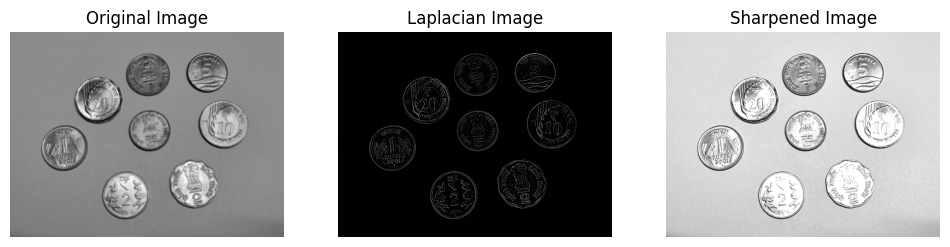

In [212]:
fig,ax = plt.subplots(1,3,figsize=(12,16))

ax[0].imshow(gray,cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(laplacian,cmap='grey')
ax[1].set_title('Laplacian Image')
ax[1].axis('off')

ax[2].imshow(sharpened_image,cmap='gray')
ax[2].set_title('Sharpened Image')
ax[2].axis('off')

going with original image since sharpened image removed too much information

# blur image to remove noise

(-0.5, 499.5, 374.5, -0.5)

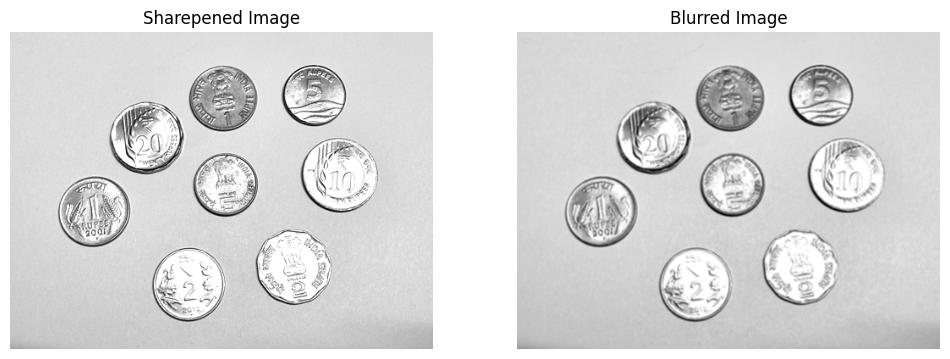

In [213]:
# image, kernel size, sigma
image_blurred = cv2.GaussianBlur(sharpened_image,(3, 3),0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(sharpened_image,cmap='grey')
ax1.set_title('Sharepened Image')
ax1.axis('off')

ax2.imshow(image_blurred, cmap='gray')
ax2.set_title('Blurred Image')
ax2.axis('off')

#Trying out different values of canny

In [214]:
def cannyplots(image):
  fig, ax = plt.subplots(2, 6, figsize=(18, 4))
  for i in range(11):
      row = i // 6
      col = (i % 6)

      #image, lower threshold, higher threshold
      edges_img = cv2.Canny(image, i * 30, i * 30 + 60)
      edges_sharpened_img = cv2.Canny(np.uint8(image_blurred), i * 30, i * 30 + 60)

      ax[row, col].imshow(edges_img, cmap='gray')
      ax[row, col].set_title(f'Canny {i * 30}-{i * 30 + 60}')
      ax[row, col].axis('off')

  ax[1, 5].imshow(image, cmap='gray')
  ax[1, 5].set_title('Image')
  ax[1, 5].axis('off')

  plt.tight_layout()
  plt.show()

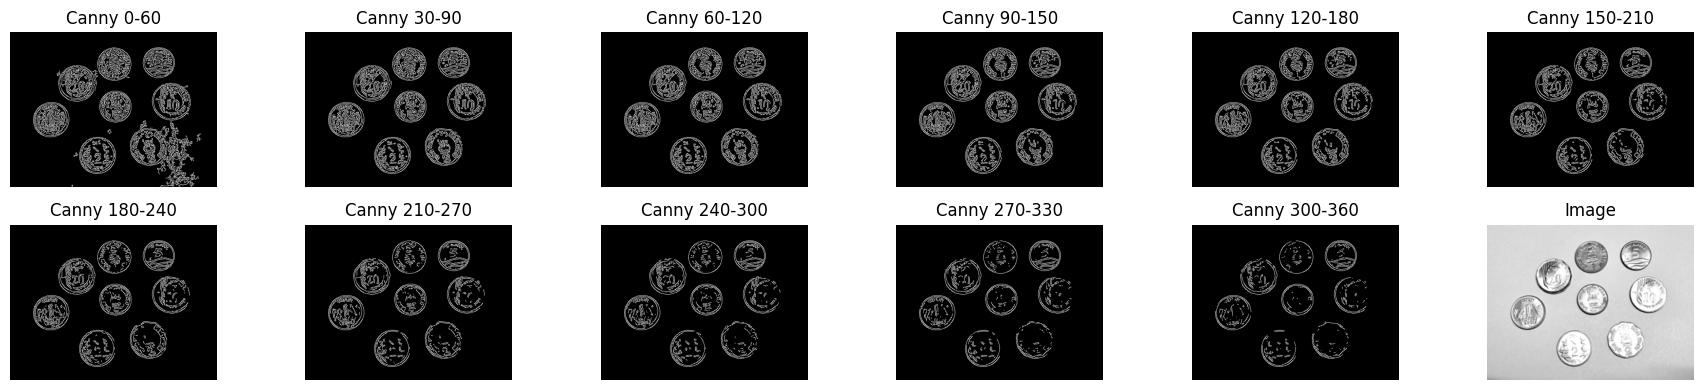

In [215]:
cannyplots(image_blurred)

# Method 1 : Non overlapping coins : Hough Transform

Works by drawing circles on image where edges are present if the concentric circles zero in some point then this point is deemed center of circle

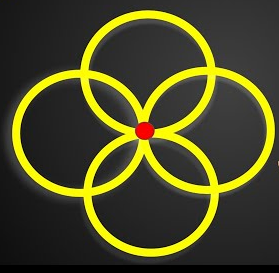

In [216]:
canny_lower = int(input("Enter appropriate value for lower threshhold : "))
canny_higher = int(input("Enter appropriate value for higher threshhold : "))

Enter appropriate value for lower threshhold : 60
Enter appropriate value for higher threshhold : 120


In [227]:
hough_image_input = image_blurred.copy()

In [228]:
circles = cv2.HoughCircles(
    hough_image_input,                         # Image input
    cv2.HOUGH_GRADIENT,                        # Detection method  cv2.HOUGH_STANDARD, cv2.HOUGH_PROBABILISTIC for lines cv2.HOUGH_GRADIENT for circles

    ############### ADJUST THESE PARAMETERS FOR BETTER DETECTION ###############

    dp=1,                                      # Inverse ratio of resolution
    minDist = gray.shape[0] // 8,              # Minimum distance between detected centers
    param1  = canny_higher,                    # Canny edge upper threshold
    param2  = 30,                              # Hough accumulator threshold - minimum 30 overlapping points with circle
    minRadius = (gray.shape[0]//15),           # Minimum coin radius
    maxRadius = (gray.shape[0]//8)             # Maximum coin radius

    ############################################################################
)

circles = circles[0]

In [229]:
print(circles)

[[208.5 297.5  41. ]
 [389.5 168.5  45.4]
 [250.5  79.5  39.2]
 [ 99.5 212.5  41.6]
 [255.5 181.5  37.2]
 [360.5  75.5  33.7]
 [331.5 276.5  42.1]
 [158.5 126.5  41. ]]


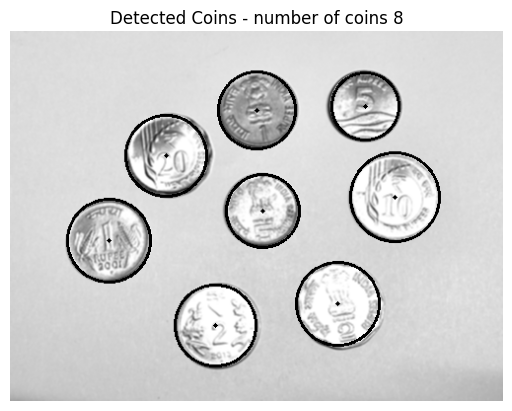

In [230]:
if circles is not None:
    circles = np.uint16(np.around(circles))                       # Convert to integers
    for circle in circles:
        x, y, r = circle                                          # Get center and radius

        # image,center,radius,color,
        cv2.circle(hough_image_input, (x, y), r, (0, 0, 0), 2)  # Draw outer circle
        cv2.circle(hough_image_input, (x, y), 0, (0, 0, 0), 3)  # Draw center

plt.imshow(hough_image_input, cmap='gray')
plt.title(f'Detected Coins - number of coins {len(circles)}')
plt.axis('off')
plt.show()

# Method 2 : Overlapping coins : Watershed

In [231]:
path = "/content/drive/MyDrive/VR/coins4.jpg"

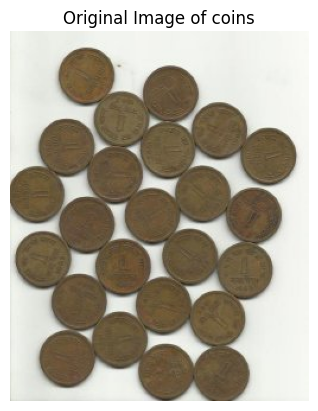

In [232]:
img = read_image(path)

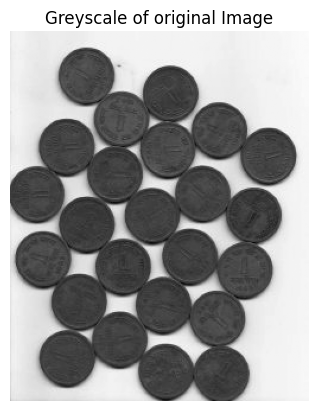

In [233]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap='gray')
plt.title("Greyscale of original Image")
plt.axis('off')
plt.show()

In [234]:
gray = downsample_images(gray)
print(gray.shape)

(312, 252)


In [235]:
laplacian, sharpened_image = high_pass_filter(gray)

# Apply threshhold


(-0.5, 251.5, 311.5, -0.5)

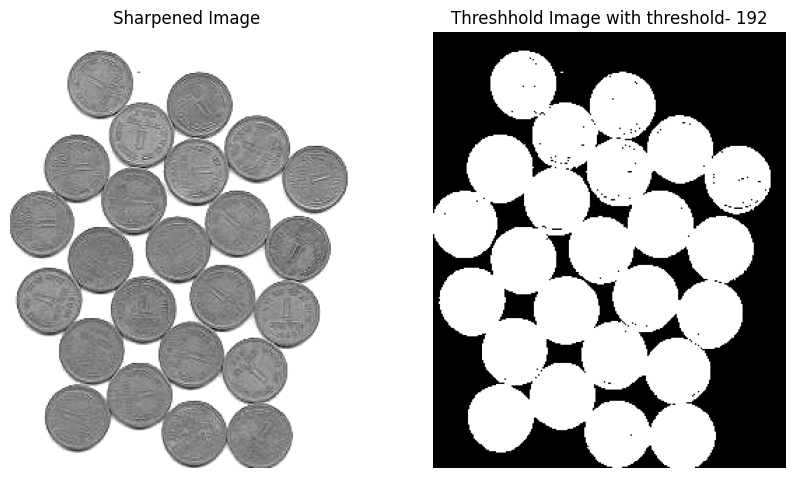

In [236]:
"""
    Lower and upper threshold are dummy as
    OTSU chooses best threshold by itself
    based on background and foreground
"""

# image, lower threshold, upper threshold, apply OTSU's [chooses optimal threshhold]  and invert the values
ret, thresh = cv2.threshold(sharpened_image,160,255,cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)

fig, ax = plt.subplots(1, 2, figsize=(10,6))

ax[0].imshow(cv2.cvtColor(sharpened_image,cv2.COLOR_BGR2RGB))
ax[0].set_title('Sharpened Image')
ax[0].axis('off')

ax[1].imshow(thresh,cmap='gray')
ax[1].set_title(f'Threshhold Image with threshold- {int(ret)}')
ax[1].axis('off')


#Fill empty spaces if region is bounded by filled regions

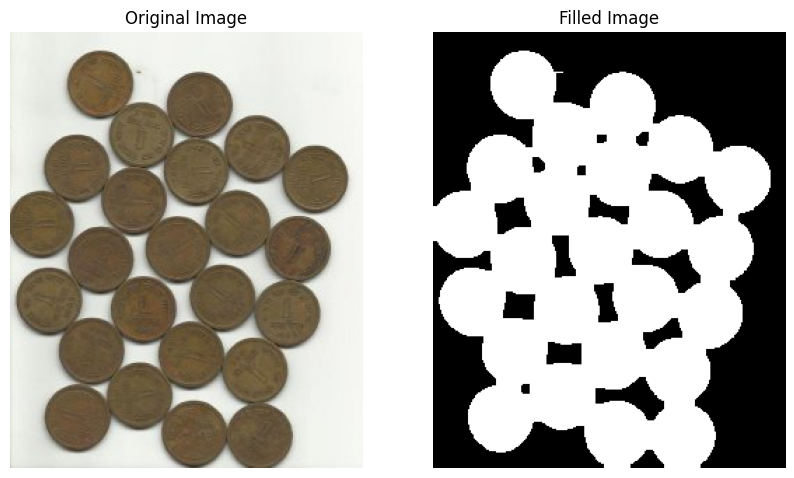

In [237]:
# morphologyEx => Closing - Dilation followed by Erosion.
# It is useful in closing small holes inside the foreground objects, or small black points on the object.

kernel = np.ones((5,5), np.uint8)
filled_image = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

fig, ax = plt.subplots(1, 2, figsize=(10,6))

ax[0].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(filled_image,cmap='gray')
ax[1].set_title('Filled Image')
ax[1].axis('off')

plt.show()

#Use this block of code only when there is too much overlapping

In [238]:
# sure_bg = cv2.erode(filled_image,kernel,iterations=1)

# fig, ax = plt.subplots(1, 2, figsize=(10,6))

# ax[0].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
# ax[0].set_title('Original Image')
# ax[0].axis('off')

# ax[1].imshow(sure_bg,cmap='gray')
# ax[1].set_title('Sure Background Image')
# ax[1].axis('off')

# plt.show()

#Extracting center of coins

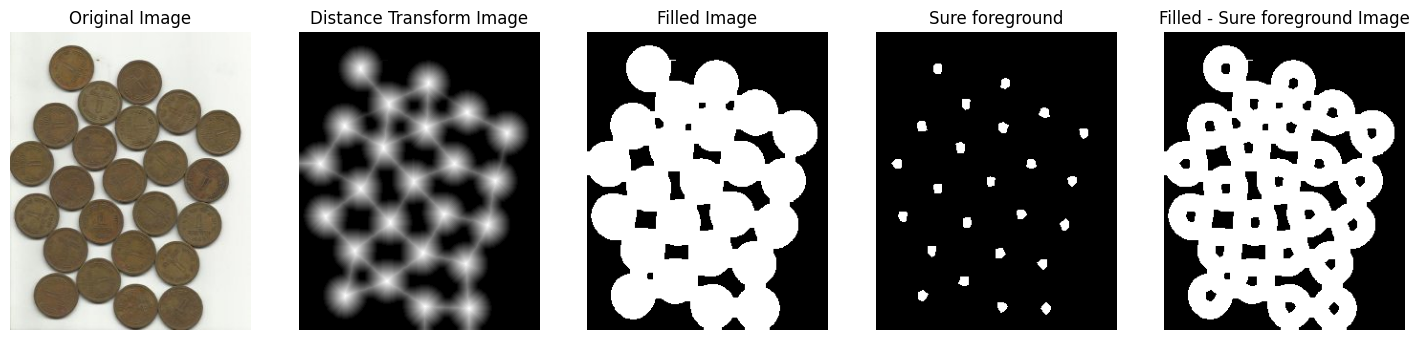

In [239]:
"""
    dist_transform = for every image find out it's closes pixel nearest to 1
    so points in centre of circle will be light and points outside circle will be darker

    cv2.threshold = extracts regions that are closer to centre of the circle
"""


dist_transform = cv2.distanceTransform(filled_image,cv2.DIST_L2,3)
ret, sure_fg = cv2.threshold(dist_transform,0.8*dist_transform.max(),255,cv2.THRESH_BINARY)

sure_fg = np.uint8(sure_fg)

if 'sure_bg' not in globals():
    sure_bg = filled_image

difference_image = cv2.subtract(filled_image,sure_fg)

fig, ax = plt.subplots(1, 5, figsize=(18,6))

ax[0].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(dist_transform,cmap='gray')
ax[1].set_title('Distance Transform Image')
ax[1].axis('off')

ax[2].imshow(filled_image,cmap='gray')
ax[2].set_title('Filled Image')
ax[2].axis('off')

ax[3].imshow(sure_fg,cmap='gray')
ax[3].set_title('Sure foreground')
ax[3].axis('off')

ax[4].imshow(difference_image,cmap='gray')
ax[4].set_title('Filled - Sure foreground Image')
ax[4].axis('off')

plt.show()

# Obtaining boundaries of coins

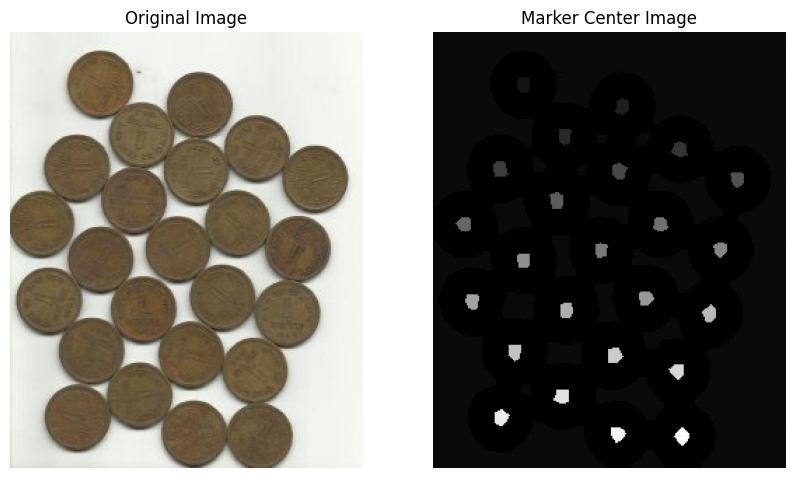

In [240]:
"""
sure_fg (Binary Image)        connectedComponents()        markers + 1         difference_image        Final markers
----------------------        ---------------------        ----------         ----------------        -------------
1  1  0  0  0                 1  1  0  0  0                 2  2  1  1  1        0   0   255 255  0      2  2  0  0  1
1  1  0  0  0                 1  1  0  0  0                 2  2  1  1  1        0   0   255 255  0      2  2  0  0  1
0  0  1  1  1                 0  0  2  2  2                 1  1  3  3  3        255 255  0   0   0      0  0  3  3  3
0  0  1  1  1                 0  0  2  2  2                 1  1  3  3  3        255 255  0   0   0      0  0  3  3  3
0  0  1  1  1                 0  0  2  2  2                 1  1  3  3  3        0   0   0   0   0      1  1  3  3  3

"""

total_coins, markers = cv2.connectedComponents(sure_fg)
markers = markers+1

#removes regions where you can see white regions in last step above
markers[difference_image==255] = 0

fig, ax = plt.subplots(1, 2, figsize=(10,6))

ax[0].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(markers,cmap='gray')
ax[1].set_title('Marker Center Image')
ax[1].axis('off')

plt.show()

Imagine a geographical map where high areas are ridges (boundaries) and low areas are valleys (objects). The watershed algorithm works like filling a terrain with water, where each region gets flooded from its lowest points until water from different sources meets. The meeting points become the boundaries.

It floods from the markers and expands outward.
When two regions meet, a watershed boundary (edge) is formed and labeled as -1.

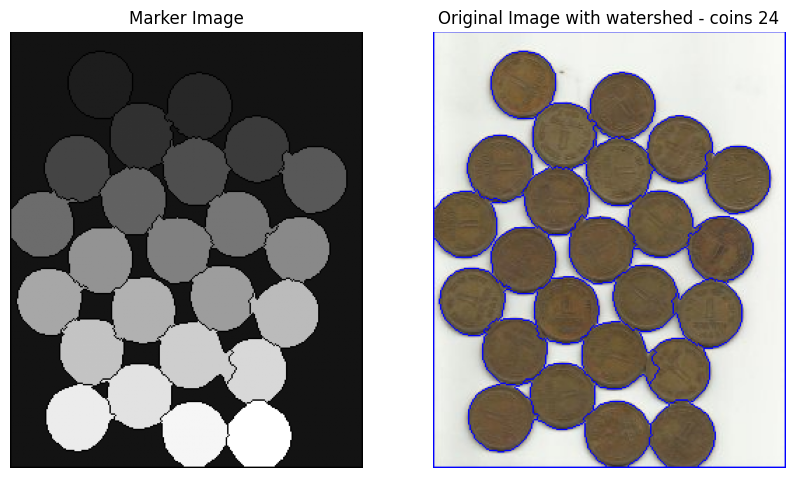

In [243]:
watershed_img = img.copy()

markers = cv2.watershed(watershed_img,markers)
img[markers == -1] = [255,0,0]

fig, ax = plt.subplots(1, 2, figsize=(10,6))

ax[0].imshow(markers,cmap='gray')
ax[0].set_title('Marker Image')
ax[0].axis('off')

ax[1].imshow(cv2.cvtColor(watershed_img,cv2.COLOR_BGR2RGB))
ax[1].set_title(f'Original Image with watershed - coins {total_coins-1}')
ax[1].axis('off')

plt.show()